# Fixed Lag Smoother

# 0. Imports

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
import dynamax.hidden_markov_model.inference as core
import dynamax.hidden_markov_model.inference_test as test

import jax.numpy as jnp
import jax.random as jr
import jax.lax as lax
from jax import vmap

# 1. Fixed Lag Smoother - Two Implementations

In [3]:
# Naive (un-vectorized) version that smooths backward inside the window
def hmm_fixed_lag_smoother_iterative(initial_distribution, transition_matrix, log_likelihoods, window_size):

    num_timesteps, num_states = log_likelihoods.shape

    def _step(carry, t):
        # Unpack the inputs
        log_normalizers, filtered_probs, predicted_probs = carry
        t_offset = t + offset

        # Get parameters for time t
        A_fwd = core._get_params(transition_matrix, 2, t_offset - 1)
        A_bwd = core._get_params(transition_matrix, 2, t_offset)
        ll = log_likelihoods[t_offset]

        # Shift window forward by 1
        log_normalizers = log_normalizers[1:]
        predicted_probs = predicted_probs[1:]
        filtered_probs = filtered_probs[1:]

        # Perform forward operation
        predicted_probs_next = core._predict(filtered_probs[-1], A_fwd)
        filtered_probs_next, log_norm = core._condition_on(predicted_probs_next, ll)
        log_normalizers = jnp.concatenate((log_normalizers, jnp.array([log_norm])))
        filtered_probs = jnp.concatenate((filtered_probs, jnp.array([filtered_probs_next])))
        predicted_probs = jnp.concatenate((predicted_probs, jnp.array([predicted_probs_next])))

        # Smooth backwards inside the window
        window_lb = t_offset - window_size + 1
        transition_backward = lax.dynamic_slice(
            transition_matrix, (window_lb, 0, 0), (window_size, num_states, num_states)
        )
        transition_backward = transition_matrix
        lls_backward = lax.dynamic_slice(log_likelihoods, (window_lb, 0), (window_size, num_states))
        _, betas = core.hmm_backward_filter(transition_backward, lls_backward)
        betas = jnp.pad(betas, ((window_size - betas.shape[0], 0), (0, 0)))

        # Compute posterior values
        def compute_posterior(filtered_probs, beta):
            smoothed_probs = filtered_probs * beta
            return jnp.where(smoothed_probs.sum(), smoothed_probs / smoothed_probs.sum(), smoothed_probs)

        smoothed_probs = vmap(compute_posterior, (0, 0))(filtered_probs, betas)

        post = core.HMMPosterior(
            marginal_loglik=log_normalizers.sum(),
            filtered_probs=filtered_probs,
            predicted_probs=predicted_probs,
            smoothed_probs=smoothed_probs,
        )

        return (log_normalizers, filtered_probs, predicted_probs), post

    # Filter on first observation
    ll = log_likelihoods[0]
    filtered_probs, log_norm = core._condition_on(initial_distribution, ll)

    # Reshape for lax.scan
    filtered_probs = jnp.pad(jnp.expand_dims(filtered_probs, axis=0), ((window_size - 1, 0), (0, 0)))
    predicted_probs = jnp.pad(jnp.expand_dims(initial_distribution, axis=0), ((window_size - 1, 0), (0, 0)))
    log_normalizers = jnp.pad(jnp.array([log_norm]), (window_size - 1, 0))

    # Pad transition and log likelihoods for backwards smoothing using lax.scan
    if transition_matrix.ndim == 3:
        transition_matrix = jnp.pad(transition_matrix, ((window_size - 2, 0), (0, 0), (0, 0)), constant_values=1)
    else:
        transition_matrix = jnp.repeat(
            jnp.expand_dims(transition_matrix, axis=0), window_size - 1 + num_timesteps, axis=0
        )
    log_likelihoods = jnp.pad(log_likelihoods, ((window_size - 2, 0), (0, 0)))
    offset = window_size - 2

    carry = (log_normalizers, filtered_probs, predicted_probs)
    _, posts = lax.scan(_step, carry, jnp.arange(1, num_timesteps))

    # Include initial values
    marginal_loglik = jnp.concatenate((jnp.array([log_normalizers.sum()]), posts.marginal_loglik))
    predicted_probs = jnp.concatenate((jnp.expand_dims(predicted_probs, axis=0), posts.predicted_probs))
    smoothed_probs = jnp.concatenate((jnp.expand_dims(filtered_probs, axis=0), posts.smoothed_probs))
    filtered_probs = jnp.concatenate((jnp.expand_dims(filtered_probs, axis=0), posts.filtered_probs))

    posts = core.HMMPosterior(
        marginal_loglik=marginal_loglik,
        filtered_probs=filtered_probs,
        predicted_probs=predicted_probs,
        smoothed_probs=smoothed_probs,
    )

    return posts

In [4]:
# Vectorized version
def hmm_fixed_lag_smoother_vectorized(initial_distribution, transition_matrix, log_likelihoods, window_size):

    num_timesteps, num_states = log_likelihoods.shape

    def _step(carry, t):
        # Unpack the inputs
        log_normalizers, filtered_probs, predicted_probs, bmatrices = carry

        # Get parameters for time t
        A_fwd = core._get_params(transition_matrix, 2, t - 1)
        A_bwd = core._get_params(transition_matrix, 2, t)
        ll = log_likelihoods[t]

        # Shift window forward by 1
        log_normalizers = log_normalizers[1:]
        predicted_probs = predicted_probs[1:]
        filtered_probs = filtered_probs[1:]
        bmatrices = bmatrices[1:]

        # Perform forward operation
        predicted_probs_next = core._predict(filtered_probs[-1], A_fwd)
        filtered_probs_next, log_norm = core._condition_on(predicted_probs_next, ll)
        log_normalizers = jnp.concatenate((log_normalizers, jnp.array([log_norm])))
        filtered_probs = jnp.concatenate((filtered_probs, jnp.array([filtered_probs_next])))
        predicted_probs = jnp.concatenate((predicted_probs, jnp.array([predicted_probs_next])))

        # Smooth inside the window in parallel
        def update_bmatrix(bmatrix):
            return (bmatrix @ A_bwd) * jnp.exp(ll)

        bmatrices = vmap(update_bmatrix)(bmatrices)
        bmatrices = jnp.concatenate((bmatrices, jnp.eye(num_states)[None, :]))

        # Compute beta values by row-summing bmatrices
        def compute_beta(bmatrix):
            beta = bmatrix.sum(axis=1)
            return jnp.where(beta.sum(), beta / beta.sum(), beta)

        betas = vmap(compute_beta)(bmatrices)

        # Compute posterior values
        def compute_posterior(filtered_probs, beta):
            smoothed_probs = filtered_probs * beta
            return jnp.where(smoothed_probs.sum(), smoothed_probs / smoothed_probs.sum(), smoothed_probs)

        smoothed_probs = vmap(compute_posterior, (0, 0))(filtered_probs, betas)

        post = core.HMMPosterior(
            marginal_loglik=log_normalizers.sum(),
            filtered_probs=filtered_probs,
            predicted_probs=predicted_probs,
            smoothed_probs=smoothed_probs,
        )

        return (log_normalizers, filtered_probs, predicted_probs, bmatrices), post

    # Filter on first observation
    ll = log_likelihoods[0]
    filtered_probs, log_norm = core._condition_on(initial_distribution, ll)

    # Reshape for lax.scan
    filtered_probs = jnp.pad(jnp.expand_dims(filtered_probs, axis=0), ((window_size - 1, 0), (0, 0)))
    predicted_probs = jnp.pad(jnp.expand_dims(initial_distribution, axis=0), ((window_size - 1, 0), (0, 0)))
    log_normalizers = jnp.pad(jnp.array([log_norm]), (window_size - 1, 0))
    bmatrices = jnp.pad(jnp.expand_dims(jnp.eye(num_states), axis=0), ((window_size - 1, 0), (0, 0), (0, 0)))

    carry = (log_normalizers, filtered_probs, predicted_probs, bmatrices)
    _, posts = lax.scan(_step, carry, jnp.arange(1, num_timesteps))

    # Include initial values
    marginal_loglik = jnp.concatenate((jnp.array([log_normalizers.sum()]), posts.marginal_loglik))
    predicted_probs = jnp.concatenate((jnp.expand_dims(predicted_probs, axis=0), posts.predicted_probs))
    smoothed_probs = jnp.concatenate((jnp.expand_dims(filtered_probs, axis=0), posts.smoothed_probs))
    filtered_probs = jnp.concatenate((jnp.expand_dims(filtered_probs, axis=0), posts.filtered_probs))

    posts = core.HMMPosterior(
        marginal_loglik=marginal_loglik,
        filtered_probs=filtered_probs,
        predicted_probs=predicted_probs,
        smoothed_probs=smoothed_probs,
    )

    return posts

# 2. Correctness of Implementation

We test the two versions by comparing their full-lag smoothed posteriors against those of the naive ```core.hmm_smoother```.




In [5]:
def test_hmm_fixed_lag_smoother(key=0, num_timesteps=5, num_states=2):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    args = test.random_hmm_args(key, num_timesteps, num_states)

    # Run the HMM smoother
    posterior = core.hmm_smoother(*args)

    # Run the HMM fixed-lag smoothers (vectorized, iterative) with full window size
    posterior_fl_vec = hmm_fixed_lag_smoother_vectorized(*args, window_size=num_timesteps)
    posterior_fl_it = hmm_fixed_lag_smoother_iterative(*args, window_size=num_timesteps)

    def compare_posteriors(post1, post2):
        assert jnp.allclose(post1.marginal_loglik, post2.marginal_loglik[-1])
        assert jnp.allclose(post1.filtered_probs, post2.filtered_probs[-1])
        assert jnp.allclose(post1.predicted_probs, post2.predicted_probs[-1])
        assert jnp.allclose(post1.smoothed_probs, post2.smoothed_probs[-1])

    # Compare posterior values of fixed-lag smoothers to those of smoother
    compare_posteriors(posterior, posterior_fl_vec)
    compare_posteriors(posterior, posterior_fl_it)


# Verify correctness
test_hmm_fixed_lag_smoother()

# 3. Timed Experiments

Window of size: 2
Iterative version took 0.749182939529419 seconds.
Vectorized version took 0.3245062828063965 seconds.
Window of size: 500
Iterative version took 0.9897620677947998 seconds.
Vectorized version took 0.5744988918304443 seconds.
Window of size: 1000
Iterative version took 1.2942566871643066 seconds.
Vectorized version took 0.7614669799804688 seconds.
Window of size: 1500
Iterative version took 1.7407751083374023 seconds.
Vectorized version took 1.0755679607391357 seconds.
Window of size: 2000
Iterative version took 2.0848448276519775 seconds.
Vectorized version took 1.2289578914642334 seconds.
Window of size: 2500
Iterative version took 2.5447559356689453 seconds.
Vectorized version took 1.5629408359527588 seconds.
Window of size: 3000
Iterative version took 3.1088812351226807 seconds.
Vectorized version took 1.8927171230316162 seconds.
Window of size: 3500
Iterative version took 3.738128185272217 seconds.
Vectorized version took 2.3711469173431396 seconds.
Window of size

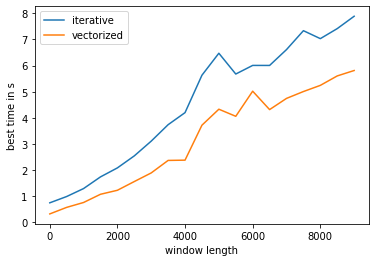

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt


def compare_runtime(key=0, num_timesteps=10000, num_states=3, window_ub=9000, window_step=500):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    args = test.random_hmm_args(key, num_timesteps, num_states)
    window_grid = np.insert(np.arange(window_step, window_ub + 1, window_step), 0, 2)

    it_times, vec_times = [], []
    for window_size in window_grid:
        print(f"Window of size: {window_size}")
        start = time.time()
        _ = hmm_fixed_lag_smoother_iterative(*args, window_size)
        it_time = time.time() - start
        it_times.append(it_time)
        print(f"Iterative version took {it_time} seconds.")
        start = time.time()
        _ = hmm_fixed_lag_smoother_vectorized(*args, window_size)
        vec_time = time.time() - start
        vec_times.append(vec_time)
        print(f"Vectorized version took {vec_time} seconds.")

    # Plot the result
    plt.figure()
    plt.plot(window_grid, it_times, label="iterative")
    plt.plot(window_grid, vec_times, label="vectorized")
    plt.xlabel("window length")
    plt.ylabel("best time in s")
    plt.legend()
    plt.show()


compare_runtime()